#Modelos de Classificação: Naive Bayes

### Importando libs  e funções

Importando libs

In [0]:
import pandas as pd
import random
import numpy as np
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix

# Importando libs de visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Importando funções

In [0]:
# Função que calcula os reais positivos
def rp(tp, fn):
    return tp + fn

# Função que calcula os reais negativos     
def rn(fp, tn):
    return fp + tn

# Função que calcula as predicoes positivas  
def pp(tp, fp):
    return tp + fp

# Função que calcula as predicoes negativas   
def pn(fn, tn):
    return fn + tn

# Função que calcula acurácia do modelo
def accuracy (tp, fp, fn, tn):
     accuracy = ((tp + tn) / (tp + tn + fp + fn))
     return (accuracy)
    
# Função que calcula a precisão 
def precision (tp, fp):
    precision =  (tp / (tp + fp)) #predições positivas
    return precision

# Função que calcula o recall
def recall(tp, fn):
    recall =  (tp / (tp + fn)) # reais positivos
    return recall

## Função que calcula o f-measure (media harmonica entre precision e recall)
def f_measure(tp, fp, fn):
    f_measure = (2 * precision(tp, fp) * recall(tp, fn)) / (recall(tp, fn) + precision(tp, fp))
    return f_measure
  
# Função que calcula o Informedness 
def informedness(tp, fp, fn, tn):
    inform = ((tp/rp(tp, fn)) - (fp/rn(fp, tn)))
    return inform

# Função que calcula o Markedness
def markdness(tp, fp, fn, tn):    
    mark = ((tp/pp(tp,fp)) - (fn/pn(fn,tn)))
    return mark

# Função de escalonamento
def feature_scaling(data):
    sc = StandardScaler()
    return sc.fit_transform(data)

# Função que gera o gráfico dos resultados de classificação
def plot_results_class(X, y, classifier, title):
    X_set, y_set = X, y
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                         np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
    plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                 alpha = 0.75, cmap = ListedColormap(('red', 'green')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    c = ListedColormap(('red', 'green'))(i), label = j)
    plt.title(title)
    plt.xlabel('Idade')
    plt.ylabel('Tarifa')
    plt.legend()
    plt.show()

### Etapa de exploração e tratamento dos dados

Importando os dados dos passageiros do titanic e selecionando uma amostragem dos dados para uma melhor visualização. O objetivo dessa tarefa de classificação é prever os passageiros sobreviventes com base nas suas informações pessoais.

Fonte: [Kaggle](https://www.kaggle.com/c/titanic/data)

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/r4phael/ml-course/master/data/titanic.csv')
df = df.sample(n=100, random_state=0)

Descrevendo o dataset

In [6]:
# Exporando o dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 495 to 681
Data columns (total 12 columns):
PassengerId    100 non-null int64
Survived       100 non-null int64
Pclass         100 non-null int64
Name           100 non-null object
Sex            100 non-null object
Age            79 non-null float64
SibSp          100 non-null int64
Parch          100 non-null int64
Ticket         100 non-null object
Fare           100 non-null float64
Cabin          29 non-null object
Embarked       100 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 10.2+ KB


In [7]:
# Visualizando o sumário das colunas numéricas do dataset
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,100.00000,100.00000,100.000000,79.000000,100.000000,100.000000,100.000000
mean,475.30000,0.43000,2.100000,27.948354,0.570000,0.430000,39.693957
std,256.15985,0.49757,0.881917,14.728176,1.046929,0.768772,51.751419
min,9.00000,0.00000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,270.00000,0.00000,1.000000,19.000000,0.000000,0.000000,8.626050
50%,501.50000,0.00000,2.000000,26.000000,0.000000,0.000000,25.039600
75%,688.75000,1.00000,3.000000,35.000000,1.000000,1.000000,37.462500
max,891.00000,1.00000,3.000000,63.000000,4.000000,4.000000,263.000000


Visualizando o dataset

In [8]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
495,496,0,3,"Yousseff, Mr. Gerious",male,NaN,0,0,2627,14.4583,NaN,C
648,649,0,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.5500,NaN,S
278,279,0,3,"Rice, Master. Eric",male,7.0,4,1,382652,29.1250,NaN,Q
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
255,256,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,29.0,0,2,2650,15.2458,NaN,C


Preenchendo os valores númericos nulos (NA) com a mediana.

In [9]:
df = df.fillna(df.median())

df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
495,496,0,3,"Yousseff, Mr. Gerious",male,26.0,0,0,2627,14.4583,NaN,C
648,649,0,3,"Willey, Mr. Edward",male,26.0,0,0,S.O./P.P. 751,7.5500,NaN,S
278,279,0,3,"Rice, Master. Eric",male,7.0,4,1,382652,29.1250,NaN,Q
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,26.0,1,0,PC 17569,146.5208,B78,C
255,256,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,29.0,0,2,2650,15.2458,NaN,C


Definindo as variáveis independentes e visualizando as 5 primeiras:

In [10]:
X = df.iloc[:, [5, 9]].values
X[:5]


array([[ 26.    ,  14.4583],
       [ 26.    ,   7.55  ],
       [  7.    ,  29.125 ],
       [ 26.    , 146.5208],
       [ 29.    ,  15.2458]])

Definindo as variáveis dependentes e visualizando as 5 primeiras:

In [11]:
y = df.iloc[:, 1].values
y[:5]


array([0, 0, 0, 1, 1])

 Criando os subconjuntos de treinamento e testes:

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

print("Tamanho do Dataset. {}".format(df.shape[0]))
print("Tamanho do Conjunto de Treinamento. {}".format(len(X_train)))
print("Tamanho do Conjunto de Testes. {}".format(len(X_test)))

Tamanho do Dataset. 100
Tamanho do Conjunto de Treinamento. 80
Tamanho do Conjunto de Testes. 20


Normalizando as features e exibindo as 5 primeiras:

In [13]:
X_train = feature_scaling(X_train)
X_test = feature_scaling(X_test)

X_train[:5]

array([[-0.2233842 ,  0.62589282],
       [ 0.50330481, -0.63776468],
       [ 0.35796701, -0.68999987],
       [-0.0780464 , -0.55753246],
       [-0.58672871, -0.2466326 ]])

Treinando o modelo de Árvore de Decisão com o Conjunto de Treinamento

### Etapa de Treinamento e Validação do Modelo

Importando e treinando o modelo com o conjunto de treinamento:

In [14]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

Prevendo os resultados do modelo criado com o conjunto de testes

In [15]:
y_pred = classifier.predict(X_test)

y_pred

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

Criando e exibindo os valores da matriz de confusão com o conjunto de testes 

In [16]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

confusion_matrix(y_test, y_pred)

array([[13,  2],
       [ 4,  1]])

Visualizando a matriz de confusão

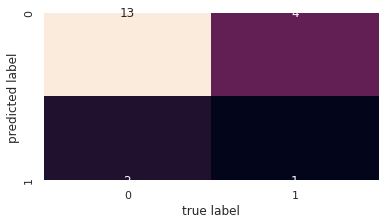

In [17]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Visualizando a métrica de **acurácia** utilizando as funções criadas e a bibilioteca sklearn:

In [18]:
accuracy(tp, fp, fn, tn)
classifier.score(X_test, y_test)

0.7

Exibindo a medida **f-measure**:

In [19]:
f_measure(tp, fp, fn)
f1_score(y_test, y_pred)  

0.25

Exibindo os resultados do conjunto de treinamento:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


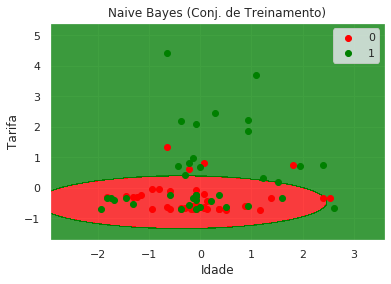

In [20]:
plot_results_class(X_train, y_train, classifier, 'Naive Bayes (Conj. de Treinamento)')

Exibindo os resultados do conjunto de testes:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


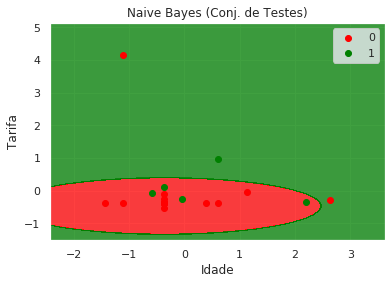

In [21]:
plot_results_class(X_test, y_test, classifier, 'Naive Bayes (Conj. de Testes)')